In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import Any

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
# from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassConfusionMatrix

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torchmetrics import Accuracy # Better for metrics in PL
import matplotlib.pyplot as plt
import numpy as np

### Data Transforms

In [7]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [8]:
#Hardcoding the mean and std values; these were calculated in nb 1
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


In [9]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [10]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

In [11]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=4, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

In [12]:
class ResNetClassifier(pl.LightningModule):
    def __init__(self, class_labels, num_classes: int, learning_rate: float = 1e-3, freeze_backbone: bool = True):
        super().__init__()
        self.save_hyperparameters() # Automatically saves all __init__ arguments as hyperparameters
        
        self.test_preds = []
        self.test_targets = []
        
        self.class_labels = class_labels
        self.confmat = MulticlassConfusionMatrix(num_classes=len(class_labels))
        
        # Load pre-trained ResNet model
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            # Freeze all parameters in the network except the final layer
            for param in self.model.parameters():
                param.requires_grad = False
            print("Backbone frozen for feature extraction.")
        else:
            print("Backbone unfrozen for fine-tuning.")

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Calculate and log accuracy
        preds = torch.argmax(outputs, dim=1)
        self.train_accuracy.update(preds, labels)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # Calculate and log accuracy
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy.update(preds, labels)
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    def configure_optimizers(self):
        # If backbone is frozen, only optimize the new fc layer
        if self.hparams.freeze_backbone:
            optimizer = optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
        else:
            # For full fine-tuning, you might use a smaller LR for the whole model
            optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        accuracy = (preds == y).float().mean()

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy, on_step=False, on_epoch=True, prog_bar=True)
        
        
        # Store predictions and targets
        self.test_preds.append(preds.detach().cpu())
        self.test_targets.append(y.detach().cpu())

        return loss
    
    
    def on_test_epoch_end(self):
        
        all_preds = torch.cat(self.test_preds)
        all_targets = torch.cat(self.test_targets)

        device = self.device  # or all_preds.device, just be consistent
        self.confmat = self.confmat.to(device)
        all_preds = all_preds.to(device)
        all_targets = all_targets.to(device)

        # Update and compute confusion matrix
        self.confmat.update(all_preds, all_targets)
        conf_matrix = self.confmat.compute()
        
        # Plot
        class_names_ = self.class_labels
        num_classes = len(class_names_)
        fig_size = max(10, num_classes * 0.3)

        plt.figure(figsize=(fig_size, fig_size))
        sns.heatmap(conf_matrix.cpu().numpy(),
                    annot=False,
                    cmap='Blues',
                    fmt='d',
                    xticklabels=class_names_,
                    yticklabels=class_names_)
        
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90, fontsize=max(6, 100 / num_classes))
        plt.yticks(rotation=0, fontsize=max(6, 100 / num_classes))
        plt.tight_layout()
        plt.show()

        # Reset confusion matrix and buffers
        self.confmat.reset()
        self.test_preds.clear()
        self.test_targets.clear()
        self.final_confusion_matrix = conf_matrix.clone().detach().cpu()


In [13]:
#Removing the Validation DataLoader progress bar between epochs
class MinimalProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # Return a dummy tqdm with no visible output to disable validation progress bar
        # Set total=0 to avoid progress display
        return tqdm(disable=True)

    def init_test_tqdm(self):
        # Same for test dataloader
        return tqdm(disable=True)

In [14]:
timestamp = datetime.now().strftime(format="%Y-%m-%d_%H-%M-%S")

In [15]:
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

data_module = DataModule(batch_size=64, num_workers=8)
data_module.setup()

Seed set to 42


In [16]:
# Initialize classifier
# Choose between freezing backbone (feature extraction) or full fine-tuning
model = ResNetClassifier(
    num_classes=len(class_names),
    class_labels=class_names,
    learning_rate=0.001,
    freeze_backbone=True # Set to False for full fine-tuning
)

Backbone frozen for feature extraction.


In [20]:
trainer = pl.Trainer(
#                     logger=logger,
#                      callbacks=[MinimalProgressBar(), checkpoint_callback, early_stop_callback], 
                     callbacks=[MinimalProgressBar()], 
                     default_root_dir="\\training_output", 
                     max_epochs=10)
trainer.fit(model, data_module)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                      | Params | Mode 
---------------------------------------------------------------------
0 | confmat        | MulticlassConfusionMatrix | 0      | train
1 | model          | ResNet                    | 11.2 M | train
2 | criterion      | CrossEntropyLoss          | 0      | train
3 | train_accuracy | MulticlassAccuracy        | 0      | train
4 | val_accuracy   | MulticlassAccuracy        | 0      | train
---------------------------------------------------------------------
25.7 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.809    Total estimated model params size (MB)
72        Modules in train mo

Epoch 9: 100%|█| 329/329 [01:35<00:00,  3.44it/s, v_num=31, train_loss_step=1.250, val_loss=1.050, val_acc=0.709, train

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 329/329 [01:35<00:00,  3.43it/s, v_num=31, train_loss_step=1.250, val_loss=1.050, val_acc=0.709, train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


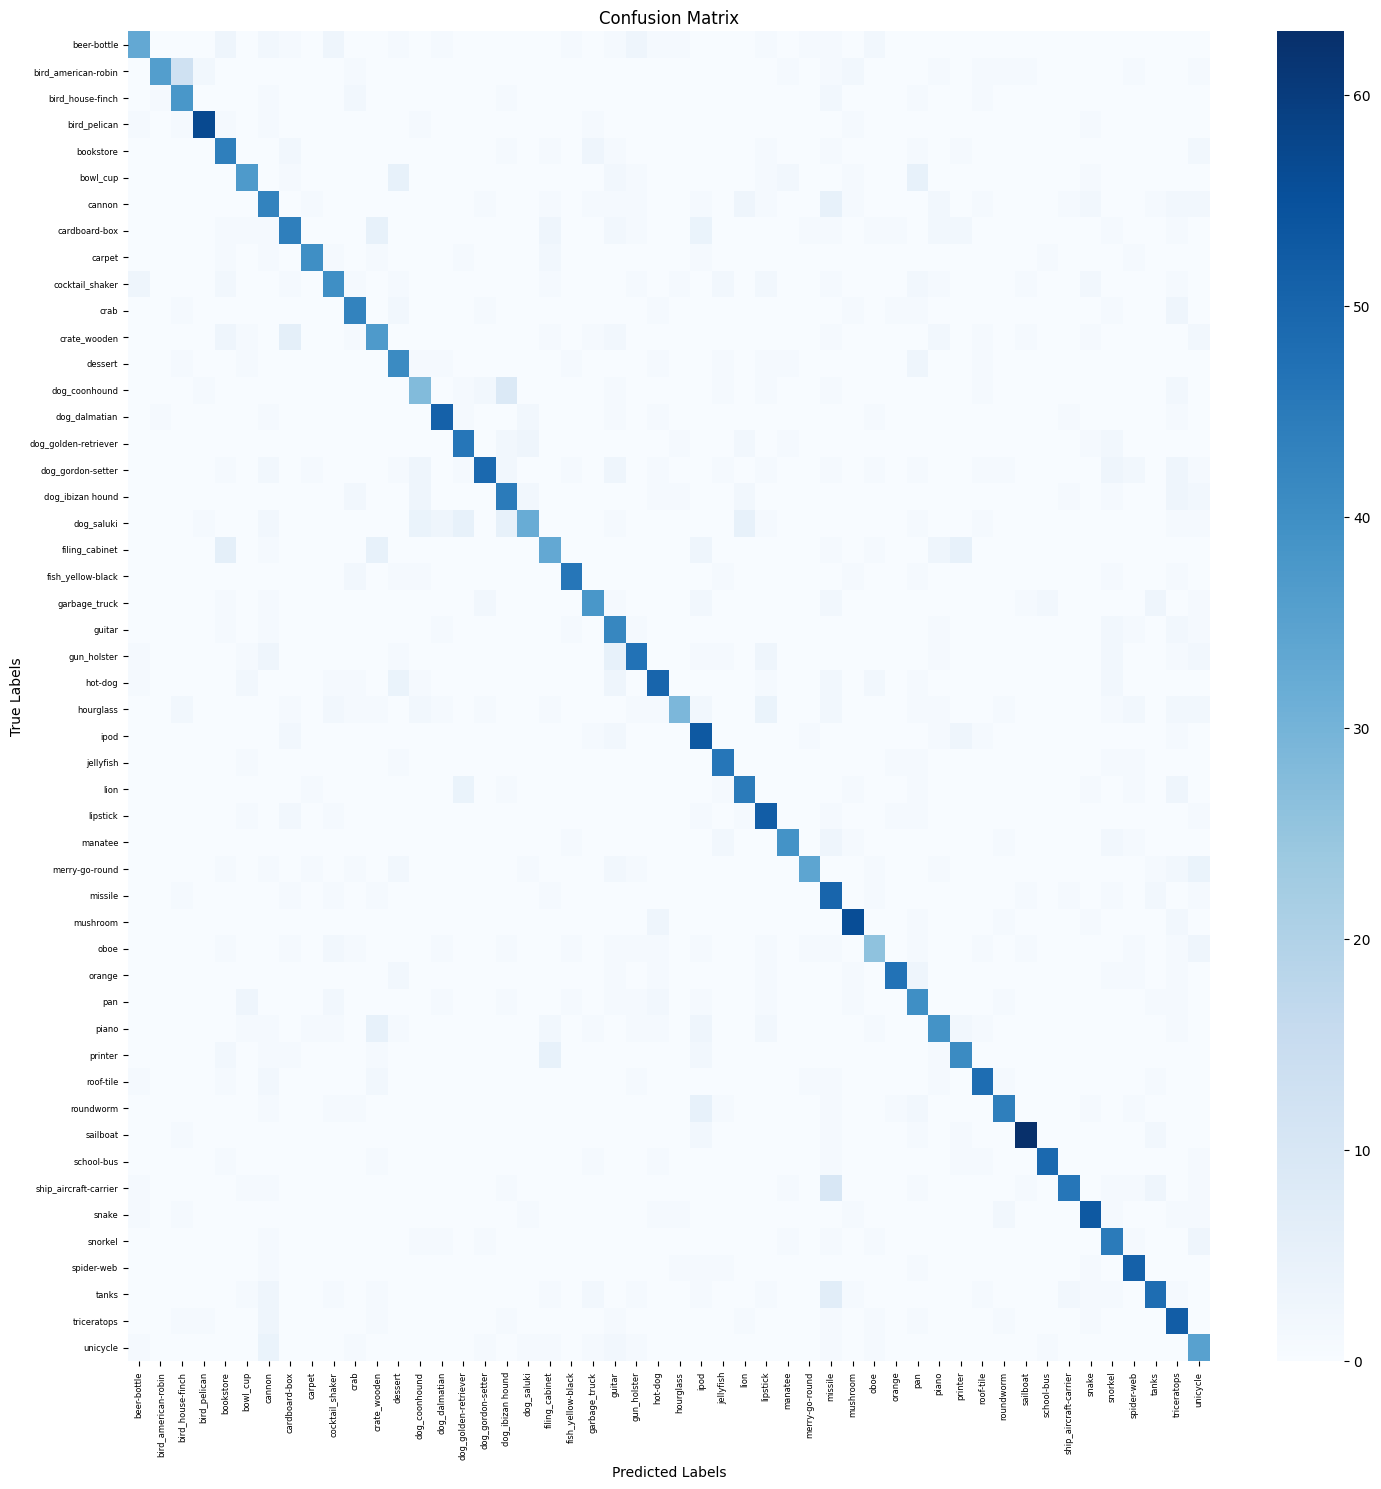

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7236666679382324
        test_loss           0.9607155919075012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [21]:
test_results = trainer.test(model, datamodule=data_module)

#### Test Accuracy: 72.36%